In [ ]:
#Colab version
from google.colab import drive
drive.mount('/content/drive')
!pip install Sastrawi


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from xgboost import XGBClassifier

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [ ]:
#Path relatives
path = '/content/drive/My Drive/NLP/data/data_worthcheck/'

#Resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
ps_dev = pd.read_csv(path+'dev.csv')
ps_dev.head()

,text_a,label
0,jek dajal ga depok bang,no
1,detikcom untung depok masuk wilayah nya ridwan...,no
2,df dom jakarta depok yg gunain vc cabang nya c...,no
3,your2rl depok jkt,no
4,doakan indonesia selamat virus corona pkb depo...,yes


In [ ]:
#ps_train= pd.read_csv('./data/data_worthcheck/train.csv', index_col=0)
ps_train= pd.read_csv(path+'train.csv', index_col=0)
ps_train.head()

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,no
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,e100ss gini buka informasi sejelas nya identit...,yes
3,neng solo wes ono terduga corona cobo neng ati...,no
4,midiahn nii akun gak takut takut nya isu coron...,no


In [ ]:
ps_test= pd.read_csv(path+'test.csv')
ps_test.head()

,text_a,label
0,jek dajal ga depok bang,no
1,detikcom untung depok masuk wilayah nya ridwan...,no
2,df dom jakarta depok yg gunain vc cabang nya c...,no
3,your2rl depok jkt,no
4,doakan indonesia selamat virus corona pkb depo...,yes


In [ ]:
data_train = ps_train.dropna(subset=['text_a'])
    
data_train.describe(include='all')

,text_a,label
count,21601,21601
unique,16221,2
top,hoax berjemur lawan corona,no
freq,5,15512


In [ ]:
data_train_single = data_train.drop_duplicates('text_a')
data_train_single.head()

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,no
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,e100ss gini buka informasi sejelas nya identit...,yes
3,neng solo wes ono terduga corona cobo neng ati...,no
4,midiahn nii akun gak takut takut nya isu coron...,no


# Classification Model

In [ ]:
stop_words = StopWordRemoverFactory().get_stop_words() #load default stopword

In [ ]:
# list of word types (nouns and adjectives) to leave in the text
defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wn.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wn.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wn.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wn.VERB
    return nltk.stem.wordnet.wn.NOUN
    
# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        #self.stemmer = nltk.stem.SnowballStemmer('indonesian') 
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        self.stemmer = stemmer
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [x for x in doc_tok if x not in stop_words]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

In [ ]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', norm='l2', tokenizer=LemmaTokenizer())
vec_tdidf

TfidfVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7fd0a0fb3350>)

In [ ]:
clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
clf

XGBClassifier(colsample_bytree=0.6, random_state=42, seed=2, subsample=0.7)

In [ ]:
#pipeline feature text
text = Pipeline([
                ('vectorizer', vec_tdidf)
                ])

In [ ]:
pipe = Pipeline([('text',text),
                 ('clf',clf)
                 ])

In [ ]:
#X dan y
target = 'label'
X_train = data_train_single["text_a"]
y_train = data_train_single["label"]
print(X_train.head())
print(y_train.head())

0    betewe buka twitter cuman ngetweet liat home b...
1    mas piyuuu mugo2 corona tuh mulut tersumpal ma...
2    e100ss gini buka informasi sejelas nya identit...
3    neng solo wes ono terduga corona cobo neng ati...
4    midiahn nii akun gak takut takut nya isu coron...
Name: text_a, dtype: object
0     no
1     no
2    yes
3     no
4     no
Name: label, dtype: object


In [ ]:
# definition of parameter grid to scan through
param_grid = {
     'clf__n_estimators': [50,100,300]
#    'clf__colsample_bytree': [0.6,0.8,1]
#    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}
# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)

In [ ]:
#pipe.named_steps['clf'].get_params()

In [ ]:
#Encoding 
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [ ]:
#hyperparameter fitting
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('text',
                                        Pipeline(steps=[('vectorizer',
                                                         TfidfVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7fd0a0fb3350>))])),
                                       ('clf',
                                        XGBClassifier(colsample_bytree=0.6,
                                                      random_state=42, seed=2,
                                                      subsample=0.7))]),
             n_jobs=1, param_grid={'clf__n_estimators': [50, 100, 300]},
             return_train_score=True)

In [ ]:
clf_test = grid_search.best_estimator_

In [ ]:
grid_search.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('text', Pipeline(steps=[('vectorizer',
                    TfidfVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7fd0a0fb3350>))])),
  ('clf',
   XGBClassifier(colsample_bytree=0.6, random_state=42, seed=2, subsample=0.7))],
 'estimator__verbose': False,
 'estimator__text': Pipeline(steps=[('vectorizer',
                  TfidfVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7fd0a0fb3350>))]),
 'estimator__clf': XGBClassifier(colsample_bytree=0.6, random_state=42, seed=2, subsample=0.7),
 'estimator__text__memory': None,
 'estimator__text__steps': [('vectorizer',
   TfidfVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7fd0a0fb3350>))],
 'estimator__text__verbose': False,
 'estimator__text__vectorizer': TfidfVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7fd0a0fb3350>),
 'estimator__text__vectorizer__analyzer': 'word',
 'estimator__text__vectorizer__binary': False,
 '

In [ ]:
grid_search.best_params_

{'clf__n_estimators': 300}

In [ ]:
def print_stats(preds, target, labels, sep='-', sep_len=40, fig_size=(10,8)):
    print('Accuracy = %.3f' % metrics.accuracy_score(target, preds))
    print(sep*sep_len)
    print('Classification report:')
    print(metrics.classification_report(target, preds))
    print(sep*sep_len)
    print('Confusion matrix')
    cm=metrics.confusion_matrix(target, preds)
    cm = cm / np.sum(cm, axis=1)[:,None]
    sns.set(rc={'figure.figsize':fig_size})
    sns.heatmap(cm, 
        xticklabels=labels,
        yticklabels=labels,
           annot=True, cmap = 'YlGnBu')
    plt.pause(0.05)

Accuracy = 0.820
----------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      2341
           1       0.47      0.72      0.57       459

    accuracy                           0.82      2800
   macro avg       0.70      0.78      0.73      2800
weighted avg       0.86      0.82      0.83      2800

----------------------------------------
Confusion matrix


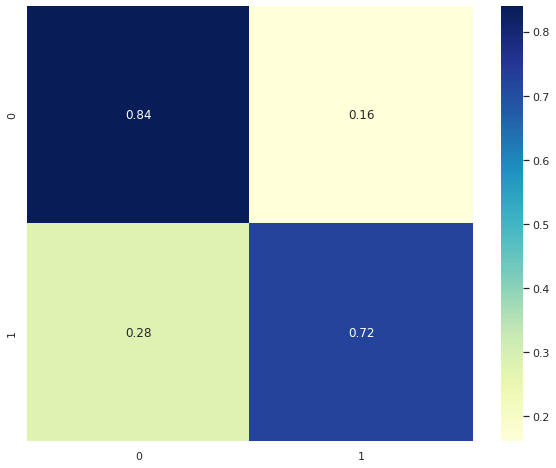

In [ ]:
# test stats
X_test = ps_test["text_a"]
y_test = ps_test["label"]
y_test = le.fit_transform(y_test)

preds = clf_test.predict(X_test)
print_stats(y_test, preds, clf_test.classes_)